# Equipotentials

Consider a binary system consisting of two stars with masses $M_1$ and $M_2$.  We'll assume that
$M_2 < M_1$.

In the corotating frame, the total potential (gravitational and centrifugal) is:

$$\Phi = - \frac{GM_1}{s_1} - \frac{GM_2}{s_2} - \frac{1}{2}\omega^2 (x^2 + y^2)$$

where $s_1$ and $s_2$ are the distances from masses 1 and 2 to a test mass $m$, and
we place the center of mass of the system at the coordinate origin.  This appears as:

![binary diagram](binary_diagram.png)

Here we write the distance of mass 1 to the center of mass as $a_1$ and that of mass 2 to the center of mass as $a_2$.

We can get the rotation frequency from Kepler's laws, and it is :

$$\omega^2 = \frac{G( M_1 + M_2)}{(a_1 + a_2)^3}$$

This allows us to rewrite our potential as:

$$\Phi = - \frac{GM_1}{s_1} - \frac{GM_2}{s_2} - \frac{1}{2}\frac{G(M_1 + M_2)}{(a_1 + a_2)^3} (x^2 + y^2)$$

We now make this dimensionless.  We scale the masses by the total masses of the system, giving:

$$\mu = \frac{M_2}{M_1 + M_2} \, ; \quad 1 - \mu = \frac{M_1}{M_1 + M_2}$$

This gives the center of mass condition:

$$\frac{M_2 a_2}{M_1 + M_2} = \frac{M_1 a_1}{M_1 + M_2}$$

$$\mu a_2 = (1 - \mu) a_1$$

or

$$\mu = \frac{a_1}{a_1 + a_2}$$

Now we scale the lengths by the orbital separation, $a_1 + a_2$, giving the dimensionless potential

$$f = \frac{(a_1 + a_2) \Phi}{G (M_1 + M_2)} = - \frac{1 - \mu}{\sigma_1} - \frac{\mu}{\sigma_2} - \frac{1}{2} (\xi^2 + \eta^2)$$

where the dimensionless lengths are:

$$\xi = \frac{x}{a_1 + a_2} \, ; \quad \eta = \frac{y}{a_1 + a_2}$$

$$\sigma_1 = \frac{s_1}{a_1 + a_2} \, ; \quad \sigma_2 = \frac{s_2}{a_1 + a_2}$$

The system with these new scalings appears as:

![binary_diagram_dimensionless.png](binary_diagram_dimensionless.png)

From the diagram above, we see:

$$\sigma_1^2 = (\xi + \mu)^2 + \eta^2$$

$$\sigma_2^2 = [\xi - (1 - \mu) ]^2 + \eta^2$$

We can now plot this potential.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [43]:
class Equipotential:
    """the general setup is two stars on the x-axis.  M_1 is the more
    massive and is at x = -a_1.  M_2 is the less massive and is at
    x = + a_2.

    center of mass tells us that: M_1 a_1 = M_2 a_2

    we work in mass units of (M_1 + M_2), and distance units of
    (a_1 + a_2)

    here mu is the mass parameter, which we can think of as

    mu = M_2 / (M_1 + M_2).

    mu = 1/2 is equal mass, but in general, with M_1 > M_2, mu
    will be less than 1/2.
    """

    def __init__(self, q):
        """
        Define an equipotential problem.

        q is the mass ratio, q = M_2 / M_1 < 1

        """

        self.q = q
        self.mu = q / (1.0 + q)

    def f(self, xi, eta):
        """Compute the dimensionless potential"""

        sigma_1 = np.sqrt((xi + self.mu)**2 + eta**2)
        sigma_2 = np.sqrt((xi - (1 - self.mu))**2 + eta**2)

        return -(1 - self.mu) / sigma_1 - self.mu / sigma_2 - 0.5 * (xi**2 + eta**2)

    def get_l1(self):
        """return the xi coordinate of the L1 point"""

        # since M_1 > M_2, we expect the L1 point to be closer to M2, so we'll
        # search from [-eps, 1-mu].  Also, we need to minimize -f

        res = optimize.minimize_scalar(lambda xi: -self.f(xi, 0), method="bounded", bounds=[-0.001*self.mu, 1-self.mu])
        return res.x

    def get_l2(self):
        """return the xi coordinate of the L2 point"""

        # L2 is on the other side of the smaller mass from the center of mass.
        # For us, the smaller mass is M_2 which is at xi = + (1 - mu), so we
        # search beyond that.  Also, we need to minimize -f

        res = optimize.minimize_scalar(lambda xi: -self.f(xi, 0), method="bounded", bounds=[1-self.mu, 10*self.mu])
        return res.x

    def get_l3(self):
        """return the xi coordinate of the L3 point"""

        # L3 is on the other side of the larger mass from the center of mass.
        # For us, the smaller mass is M_1 which is at xi = - mu, so we
        # search beyond that.  Also, we need to minimize -f

        res = optimize.minimize_scalar(lambda xi: -self.f(xi, 0), method="bounded", bounds=[-10*self.mu, -self.mu])
        return res.x

    def plot(self, *, xi_min=-2.0, xi_max=2.0, eta_min=-2.0, eta_max=2.0, N=128):
        """plot the equipotentials"""

        _xi = np.linspace(xi_min, xi_max, N)
        _eta = np.linspace(eta_min, eta_max, N)

        xi, eta = np.meshgrid(_xi, _eta)

        V = np.abs(self.f(xi, eta))
        V_median = np.median(V)
        print(V.min(), V.max(), V_median)
        
        fig, ax = plt.subplots()
        ax.imshow(np.log10(V), origin="lower", cmap="YlGnBu",
                  extent=[xi_min, xi_max, eta_min, eta_max],
                  vmax=V_median)

        Vmin = 1.5
        Vmax = 100.0
        nC = 20
        C = np.logspace(np.log10(Vmin), np.log10(Vmax), nC)
        ax.contour(xi, eta, V, C, colors="0.5")

        # plot the Lagrange points
        xi1 = self.get_l1()
        xi2 = self.get_l2()
        xi3 = self.get_l3()

        ax.scatter([xi1, xi2, xi3], [0, 0, 0], color="C1", marker="x")
        return fig

In [44]:
e = Equipotential(0.25)
e.f(2,-2)

-4.35481841016978

1.420000828923267 203.60560791181504 2.0232270575584854


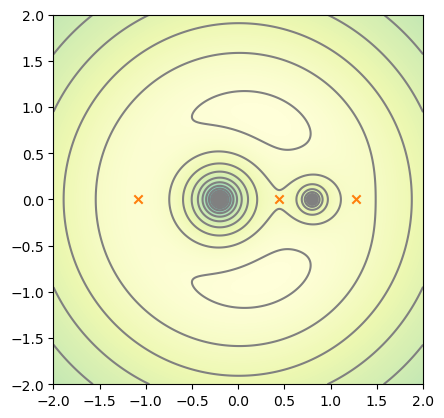

In [45]:
fig = e.plot(N=512)

In [46]:
e.get_l1()

0.4380762762506286

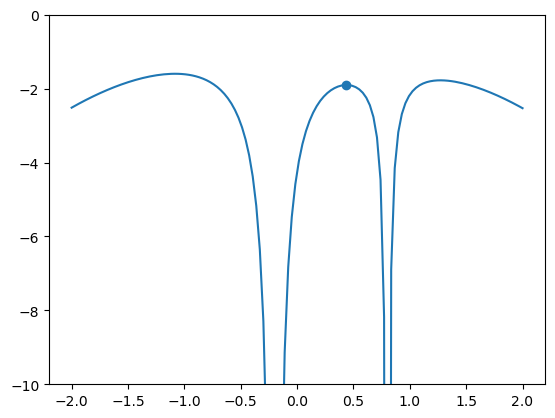

In [47]:
xi = np.linspace(-2, 2, 128)
fig, ax = plt.subplots()
ax.plot(xi, e.f(xi, 0))
ax.set_ylim(-10, 0)
ax.scatter(e.get_l1(), e.f(e.get_l1(), 0))

In [14]:
e.mu

0.5